In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using ModelingToolkit, FenrirForNeuro, OrdinaryDiffEq

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)

keys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
values(θ) = map(θᵢ -> θᵢ[2], θ)

values (generic function with 1 method)

In [8]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.3 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [9]:
@parameters l φ₀
θ_pd = [l => 3]
pd_prior, pd = get_Pendulum(θ_pd)
pd_proj = [1 0]
pd_observation = generate_data(pd, pd_proj, 0, 1e-2)

# @parameters gNa gK
# θ_hh = [gNa => 25, gK => 7]
# hh_prior, hh = get_SinglecompartmentHH(θ_hh)

# hh_proj = [1 0 0 0]
# hh_observation = generate_data(hh, hh_proj, 0, 1e-2)

@parameters gNa gK gleak
θ_hh = [gNa => 25, gK => 7, gleak => 0.1]
hh_prior, hh = get_SinglecompartmentHH(θ_hh)

hh_proj = [1 0 0 0]
hh_observation = generate_data(hh, hh_proj, 0, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100.0], u = [[-70.0], [-69.99999986016917], [-69.9999997204781], [-69.99999958092664], [-69.99999944151466], [-69.99999930224202], [-69.99999916310858], [-69.9999990241142], [-69.99999888525873], [-69.99999874654203]  …  [-65.41773466442645], [-65.42231183298583], [-65.42688443476916], [-65.4314524743088], [-65.43601595613706], [-65.44057488478626], [-65.44512926478873], [-65.44967910067682], [-65.45422439698282], [-65.45876515823909]])

In [10]:
# plot tRMSE and pRMSE
BASE_PATH = RESULTS_PATH * "pd/1p/single_pendulum/"
pd_rk_trajectories = import_csvs(BASE_PATH * "rk4/l2", readdir(BASE_PATH * "rk4/l2"), [keys(θ_pd)..., :loss, :T])
pd_rk_last_rows = get_last_rows(pd_rk_trajectories)
pd_fenrir_trajectories = import_csvs(BASE_PATH * "fenrir/learned_diff", readdir(BASE_PATH * "fenrir/learned_diff"), [keys(θ_pd)..., :κ², :loss, :T])
pd_fenrir_last_rows = get_last_rows(pd_fenrir_trajectories)
pd_diffS_trajectories = import_csvs(BASE_PATH * "fenrir/tempered_diff", readdir(BASE_PATH * "fenrir/tempered_diff"), [keys(θ_pd)..., :κ², :loss, :T])
pd_diffS_last_rows = get_last_rows(pd_diffS_trajectories)


BASE_PATH = RESULTS_PATH * "hh/3p/simple/"
hh_rk_trajectories = import_csvs(BASE_PATH * "rk4/l2", readdir(BASE_PATH * "rk4/l2"), [keys(θ_hh)..., :loss, :T])
hh_rk_last_rows = get_last_rows(hh_rk_trajectories)
hh_fenrir_trajectories = import_csvs(BASE_PATH * "fenrir/learned_diff", readdir(BASE_PATH * "fenrir/learned_diff"), [keys(θ_hh)..., :κ², :loss, :T])
hh_fenrir_last_rows = get_last_rows(hh_fenrir_trajectories)
hh_diffS_trajectories = import_csvs(BASE_PATH * "fenrir/tempered_diff", readdir(BASE_PATH * "fenrir/tempered_diff"), [keys(θ_hh)..., :κ², :loss, :T])
hh_diffS_last_rows = get_last_rows(hh_diffS_trajectories)

Row,gNa,gK,gleak,κ²,loss,T
,Float64,Float64,Float64,Float64,Float64,Float64
1,24.9104,6.98365,0.0999319,1193.78,1347.9,10261.5
2,24.9104,6.98365,0.0999319,1193.78,1347.9,10139.8
3,24.9104,6.98365,0.0999319,1193.78,1347.9,11827.7
4,25.0103,6.98256,0.100007,1193.78,1457.51,9572.34
5,24.9104,6.98365,0.0999319,1193.78,1347.9,9552.36
6,24.9104,6.98365,0.0999319,1193.78,1347.9,11933.1
7,25.0103,6.98256,0.100007,1193.78,1457.51,11541.1
8,25.0049,6.98964,0.0999877,1193.78,1591.63,11805.8
9,25.0103,6.98256,0.100007,1193.78,1457.51,15711.2


In [11]:
hh_t_obs, u_obs = simulate(hh, 1e-2)
hh_u_rk = map(x -> simulate(remake(hh, p=x), 1e-2)[2], eachrow(hh_rk_last_rows[!, keys(θ_hh)]))
hh_u_fenrir = map(x -> simulate(remake(hh, p=x), 1e-2)[2], eachrow(hh_fenrir_last_rows[!, keys(θ_hh)]))
hh_u_diffS = map(x -> simulate(remake(hh, p=x), 1e-2)[2], eachrow(hh_diffS_last_rows[!, keys(θ_hh)]))
hh_tRMSEs_rk = map(x -> tRMSE(x * hh_proj', u_obs * hh_proj'), hh_u_rk)
hh_tRMSEs_fenrir = map(x -> tRMSE(x * hh_proj', u_obs * hh_proj'), hh_u_fenrir)
hh_tRMSEs_diffS = map(x -> tRMSE(x * hh_proj', u_obs * hh_proj'), hh_u_diffS)

pd_t_obs, u_obs = simulate(pd, 1e-2)
pd_u_rk = map(x -> simulate(remake(pd, p=x), 1e-2)[2], eachrow(pd_rk_last_rows[!, keys(θ_pd)]))
pd_u_fenrir = map(x -> simulate(remake(pd, p=x), 1e-2)[2], eachrow(pd_fenrir_last_rows[!, keys(θ_pd)]))
pd_u_diffS = map(x -> simulate(remake(pd, p=x), 1e-2)[2], eachrow(pd_diffS_last_rows[!, keys(θ_pd)]))
pd_tRMSEs_rk = map(x -> tRMSE(x * pd_proj', u_obs * pd_proj'), pd_u_rk)
pd_tRMSEs_fenrir = map(x -> tRMSE(x * pd_proj', u_obs * pd_proj'), pd_u_fenrir)
pd_tRMSEs_diffS = map(x -> tRMSE(x * pd_proj', u_obs * pd_proj'), pd_u_diffS)

100-element Vector{Float64}:
 0.015484871071505153
 0.015484871071551864
 0.015484868159489159
 0.015484871071505153
 0.015484871071551864
 0.015484871071551864
 0.015484871071505153
 0.015484871071505153
 0.015484871071551864
 0.015484871071551864
 ⋮
 0.015484868159489159
 0.015484868159489159
 0.015484871071551864
 0.015484871071505153
 0.015484868159489159
 0.015484871071505153
 0.015484871071505153
 0.015484868159489159
 0.015484871071505153

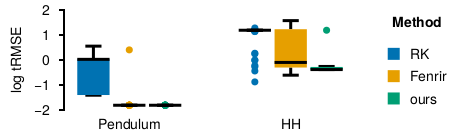

In [13]:
f = Figure(size=(HALF_WIDTH, HEIGHT), figure_padding=5)
gap = 1.5
# pos = [1.0, 2.0, 3.0, 4.0]
# pos[3:4] .+= gap
pos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
pos[4:6] .+= gap
ax1 = Axis(f[1, 1], ylabel="log tRMSE", xticks=([mean(pos[1:3]), mean(pos[4:6])], ["Pendulum", "HH"]); PLOT_DEFAULTS..., ytrimspine=true, xtrimspine=true)

l1 = boxplot!(ax1, fill(pos[1], 95), log10.(pd_tRMSEs_rk), color=Makie.wong_colors()[1], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="RK")
l2 = boxplot!(ax1, fill(pos[2], 100), log10.(pd_tRMSEs_fenrir), color=Makie.wong_colors()[2], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="Fenrir")
l3 = boxplot!(ax1, fill(pos[3], 100), log10.(pd_tRMSEs_diffS), color=Makie.wong_colors()[3], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="ours")

boxplot!(ax1, fill(pos[4], 95), log10.(hh_tRMSEs_rk), color=Makie.wong_colors()[1], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="RK")
boxplot!(ax1, fill(pos[5], 100), log10.(hh_tRMSEs_fenrir), color=Makie.wong_colors()[2], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="Fenrir")
boxplot!(ax1, fill(pos[6], 100), log10.(hh_tRMSEs_diffS), color=Makie.wong_colors()[3], width=1, gap=0.1, whiskerwidth=0.5, markersize=5, label="ours")

for ax in [ax1]
    hidespines!(ax, :t, :r)
    hidedecorations!(ax, grid=true, ticks=false, label=false, ticklabels=false)
end

leg = Legend(f[1, 2], [l1, l2, l3], ["RK", "Fenrir", "ours"], "Method", halign=:right, labelsize=7, size=2, patchsize=(6, 6), titlesize=7, framevisible=false)
colgap!(f.layout, 1, Relative(0.05))
ylims!(ax1, -2, 2)
hidespines!(ax1, :b)
hidexdecorations!(ax1, grid=true, ticks=true, label=false, ticklabels=false)

f

In [14]:
save(joinpath(FIGURES_PATH, "figure1.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
